# How much decimation is too much?

Here we show the impact of decimation on the characteristic length of the mesh.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import polpo.preprocessing.dict as ppdict
from polpo.mesh.geometry import centroid2farthest_vertex
from polpo.mesh.surface import PvSurface
from polpo.preprocessing import BranchingPipeline, IdentityStep
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.decimation import PvDecimate

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
session_subset = np.random.choice(np.arange(1, 27))

mesh_loader = (
    MeshLoader(
        subject_subset=["01"],
        struct_subset=["L_Hipp"],
        session_subset=[session_subset],
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + PvSurface
)

raw_mesh = mesh_loader()

session_subset

np.int64(5)

In [3]:
decimation_targets = [0.95, 0.9, 0.8, 0.5, 0.2, 0]


multi_decimation_pipe = BranchingPipeline(
    [
        (
            PvDecimate(target_reduction=target_reduction, volume_preservation=True)
            + PvSurface
            if target_reduction
            else IdentityStep()
        )
        for target_reduction in decimation_targets
    ],
    merger=lambda data: dict(zip(decimation_targets, data)),
)

meshes = multi_decimation_pipe(raw_mesh)


[mesh.n_points for mesh in meshes.values()]

[127, 252, 502, 1252, 2002, 2502]

In [4]:
np.amax([np.sum(mesh.volume) for mesh in meshes.values()])

np.float64(3674.2668726564752)

In [5]:
max_edge_lengths = np.array([np.amax(mesh.edge_lengths) for mesh in meshes.values()])
median_edge_lengths = np.array(
    [np.median(mesh.edge_lengths) for mesh in meshes.values()]
)

max_edge_lengths, median_edge_lengths

(array([9.59674358, 7.63264751, 6.4765296 , 5.32241917, 4.82180786,
        2.03753066]),
 array([4.33092594, 2.99716091, 2.11263514, 1.301808  , 1.03224313,
        0.92778929]))

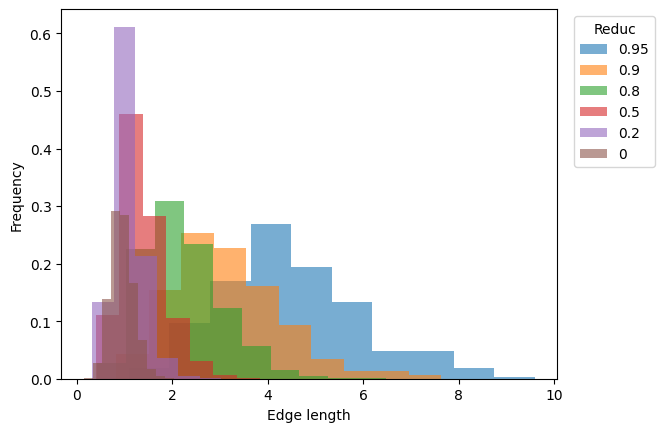

In [6]:
_, ax = plt.subplots()

for target_red, mesh in meshes.items():
    edge_lengths = mesh.edge_lengths
    ax.hist(
        edge_lengths,
        label=target_red,
        alpha=0.6,
        weights=1 / edge_lengths.size * np.ones_like(edge_lengths),
    )


ax.set_xlabel("Edge length")
ax.set_ylabel("Frequency")
ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left")

In [7]:
c2farthest = np.array(centroid2farthest_vertex(meshes.values()))

c2farthest

array([22.66272926, 22.24136734, 22.13410568, 22.11614799, 22.2365303 ,
       22.34024041])

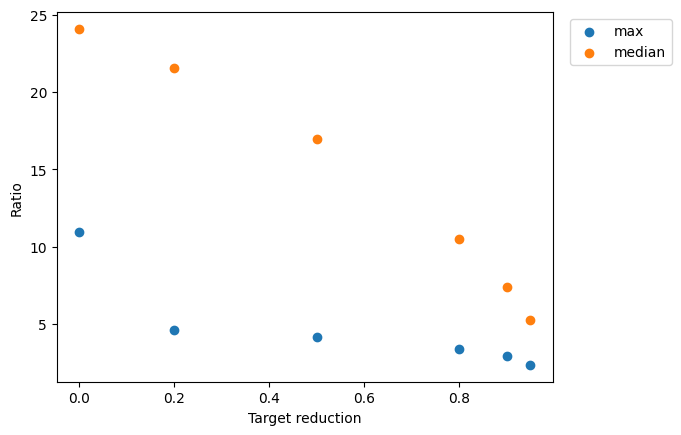

In [8]:
_, ax = plt.subplots()

ax.scatter(decimation_targets, c2farthest / max_edge_lengths, label="max")
ax.scatter(decimation_targets, c2farthest / median_edge_lengths, label="median")

ax.set_ylabel("Ratio")
ax.set_xlabel("Target reduction")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left");

## Further reading

* [How much decimation is too much? A varifold perspective](./varifold_decimation_charlen_dist.ipynb)